Let's see what we can do with my first TICCL runs! Done on 4 SoNaR subcorpora:

1. Newspapers
2. Periodicals/magazines
3. Websites
4. Wikipedia

Using two pipelines: with indexer and with indexerNT.

In this notebook we'll focus on the indexer (non-NT) data.

First step: load the data and get it in a format we can work with. Let's do that with `pandas`.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import functools  # lru_cache
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as scop
import csv
import seaborn as sns
import corner

/Users/pbos/sw/miniconda3/envs/ticclat/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
class Corpus():
    """
    For a bit of order and structure, let's make this dummy class,
    which may be extended later if necessary.
    """
    pass

In [4]:
websites = Corpus()

# Freq
_Computed with `FoLia-stats`, but in this case they were already provided._

In [5]:
websites.freq = pd.read_csv('sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv', sep='\t', names=['word', 'number', 'other_number', 'decimal_number'])

In [6]:
# websites.freq

What are the columns really? Perhaps the decimal number is the (cumulative) percentage of that word in the total corpus?

In [7]:
# (websites.freq.number/websites.freq.number.sum()).cumsum()

No, that doesn't really fit at all... The third column may be a running sum of the first one...

In [8]:
# websites.freq.number.cumsum() == websites.freq.other_number

Ok, that seems to be close...

# Clean

_Computed with `TICCL-unk`_

Anyway, it doesn't seem to be used by TICCL. In the clean files, we only see the first column being used as frequency/count, but with the added artifrq added to it in case of words in the lexicon:

In [9]:
websites.clean = pd.read_csv('sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.clean', sep='\t', names=['word', 'counts'])

In [10]:
# websites.clean
len(websites.clean)

1099151

So this list is a LOT longer than the original one. I guess a lot of lexicon words were added. Those should have count exactly 1000000000...

In [11]:
sum(websites.clean.counts == 100000000), len(websites.clean) - (sum(websites.clean.counts == 100000000) + len(websites.freq))

(1015180, 11811)

Right, so 11811 "words" out of 72160 were filtered out by clean and 1015180 were added from the lexicon.

The punct file should contain punctuation "corrected" words and the unk file should contain "unknown" words. Not sure what that meant anymore...

NO, THERE'S ALSO OVERLAP

In [12]:
websites.punct = pd.read_csv('sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.punct', sep='\t', names=['word', 'correction'])

In [13]:
len(websites.punct)

791

In [14]:
# websites.punct

In [15]:
websites.unk = pd.read_csv('sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.unk', sep='\t', names=['word', 'counts'])

In [16]:
len(websites.unk)

35

In [17]:
# websites.unk

Most filtered out words are not saved anywhere, it seems.

In [18]:
"Nino')Vieira" in websites.clean.word

False

So what words does punct contain then? The ones that even after trimming punctuation were not found to be clean? Even adding those we still have about 11k words unaccounted for, so indeed most cleaned-out words are gone.

Anyway...
## Nice plot time

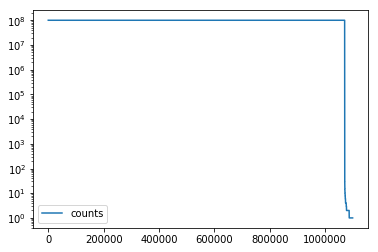

In [19]:
websites.clean.plot(logy=True)

Right, that doesn't work because of artifrq. Let's correct for that:

In [20]:
websites.clean[:10].apply(lambda x: (x['word'], x.counts), axis=1, broadcast=True)

/Users/pbos/sw/miniconda3/envs/ticclat/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The broadcast argument is deprecated and will be removed in a future version. You can specify result_type='broadcast' to broadcast the result to the original dimensions
  """Entry point for launching an IPython kernel.


,word,counts
0,de,100168251
1,van,100115806
2,het,100075171
3,en,100074895
4,een,100064640
5,in,100061126
6,op,100030138
7,is,100030067
8,met,100029293
9,voor,100028476


In [21]:
# THIS IS SOOOO SLOOOOW!
# websites.clean_no_artifrq = websites.clean.apply(lambda x: (x['word'], x['counts']-100000000 if x['counts']>=100000000 else x['counts']), axis=1, broadcast=True)
# better:
websites.clean_no_artifrq = websites.clean[['word', 'counts']].copy()
websites.clean_no_artifrq.loc[websites.clean_no_artifrq['counts'] >= 100000000, 'counts'] -= 100000000

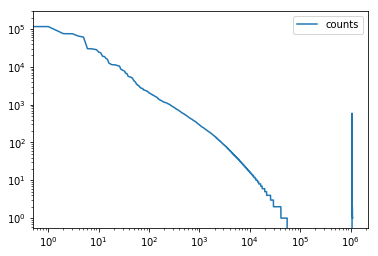

In [22]:
websites.clean_no_artifrq.plot(logx=True, logy=True)

Let's see if we can compare that / fit to a Zipf curve.

In [23]:
@functools.lru_cache(maxsize=10)
def zipf_normalization(N, s):
    return sum(1 / np.arange(1, N + 1)**s)


def zipf_from_ranks(ranks, *, s=1):
    return 1/ranks**s / zipf_normalization(len(ranks), s)


def zipf(N, *, s=1):
    ranks = np.arange(1, N + 1)
    return zipf_from_ranks(ranks, s=s)


def zipf_mandelbrot(N, *, q=0, s=1):
    ranks_plus_q = np.arange(1, N + 1) + q
    return zipf_from_ranks(ranks_plus_q, s=s)

Remarkably good fit with no parameter tweaking at all!

Actually, it makes sense to have an index starting from 1 here, to make plotting in log-log nicer.

In [24]:
websites.clean_no_artifrq.index += 1

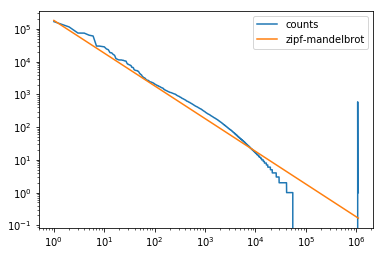

In [25]:
fig, ax = plt.subplots(1, 1)
websites.clean_no_artifrq.plot(logx=True, logy=True, ax=ax, legend=False)
N = len(websites.clean_no_artifrq)
ax.plot(np.arange(1, N + 1), websites.clean_no_artifrq.counts.sum() * zipf_mandelbrot(N),
       label='zipf-mandelbrot')
ax.legend()

What about the fraction?

(-1, 1)

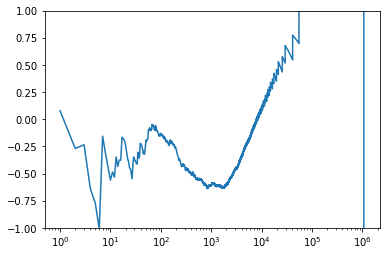

In [26]:
plt.semilogx(1 - websites.clean_no_artifrq.counts/(websites.clean_no_artifrq.counts.sum() * zipf_mandelbrot(N)))
plt.ylim(-1, 1)

And the KL-divergence (in **bits**, i.e. using `log2`) of the data compared to the theoretical Zipf-curve?

In [27]:
def KLdiv(data, model):
    data_masked = np.ma.masked_array(data, mask=data <= 0)
    return -np.sum((data_masked * np.log2(model / data_masked)))

In [28]:
KLdiv(websites.clean_no_artifrq.counts/websites.clean_no_artifrq.counts.sum(), zipf_mandelbrot(N))

0.5616274651006208

0.5 bits, is that good? Should compare to the entropy of the data:

In [29]:
def entropy(p):
    return -np.sum(p * np.log2(p))

In [30]:
entropy(websites.clean_no_artifrq.counts/websites.clean_no_artifrq.counts.sum())

/Users/pbos/sw/miniconda3/envs/ticclat/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


10.738007343684355

So, only 5% information is lost in the Zipf-approximation of the data, i.e. you need about 5% more bits to encode the "true" distribution (the observed data, the counts) compared to an optimal encoding based on a Zipf-curve. This seems pretty good to me.

In principle, you could try to fit the parameters on a minimum KLdiv. Let's try, why not.

In [31]:
scop.minimize(lambda parameter_array: KLdiv(websites.clean_no_artifrq.counts/websites.clean_no_artifrq.counts.sum(), zipf_mandelbrot(N, q=parameter_array[0], s=parameter_array[1])),
              x0=[0, 1], bounds=[(0, None), (0, None)])

      fun: 0.4652068612319095
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.96376176e-01, -7.00550729e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 5
   status: 0
  success: True
        x: array([0.        , 1.08957528])

Ok, nice, `q` indeed stays at zero, `s` is only a bit higher than 1 and the KL-divergence is only very slightly lower. So indeed, the "default" Zipf curve with power 1 is a very good fit already.

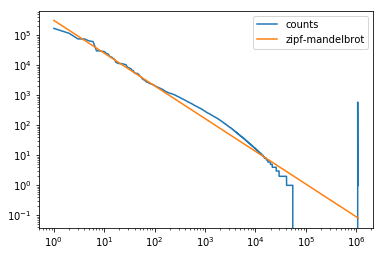

In [32]:
fig, ax = plt.subplots(1, 1)
websites.clean_no_artifrq.plot(logx=True, logy=True, ax=ax, legend=False)
N = len(websites.clean_no_artifrq)
ax.plot(np.arange(1, N + 1), websites.clean_no_artifrq.counts.sum() * zipf_mandelbrot(N, q=0, s=1.08957528),
       label='zipf-mandelbrot')
ax.legend()

Yeah, that looks slightly better by eye, but nothing amazing.

# Back to data loading

Still have a few things to load: anahash, confuslist.index, short.ldcalc, ldcalc.ambi, ldcalc and ldcalc.ranked for the non-NT run and also corpusfoci (part of anahash) for the NT run.

## Anahash

In [33]:
websites.anahash = pd.read_csv('sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.clean.anahash', sep='~',
                               index_col=0, names=['anahash', 'words'])
websites.anahash.head()

,words
anahash,
10510100501,à#ú
11040808032,E#e
11592740743,N#n
12166529024,R#r
12762815625,T#t


Hmm, how do we load such a data file into Pandas efficiently? Asked data SIG. In the meantime, let's try this (https://stackoverflow.com/questions/17116814/pandas-how-do-i-split-text-in-a-column-into-multiple-rows):

In [34]:
def load_anahash_first_try():
    anahash = pd.read_csv('sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.clean.anahash', sep='~',
                                   index_col=0, names=['anahash', 'words'],
                                   converters={'words': lambda w: tuple(w.split('#'))})
    anahash['words'][:20].apply(pd.Series, 1).stack()
    anahash['words'][:20]
    return anahash

In [35]:
# websites.anahash = load_anahash()

Really weird, some `\n`s aren't read as newlines! Sublime Text has no problem with them... What's up? Wrong encoding?

In [36]:
# websites.anahash = pd.read_csv('sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.clean.anahash',
#                                sep='~', quoting=csv.QUOTE_NONE,
#                                index_col=0, names=['anahash', 'words'],
#                                converters={'words': lambda w: tuple(w.split('#'))}, encoding='utf-8')
# websites.anahash.head(20)

That's better. Try again:

In [37]:
# websites.anahash[:20]['words'].apply(pd.Series, 1).stack()

Awesome. Now in one go?

In [38]:
# websites.anahash = pd.read_csv('sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.clean.anahash',
#                                sep='~', quoting=csv.QUOTE_NONE,
#                                index_col=0, names=['anahash', 'words'],
#                                converters={'words': lambda w: pd.Series(w.split('#'))}, encoding='utf-8')
# websites.anahash.head(20)

Ok that doesn't work. Let's stick to two (or actually four) steps then.

In [39]:
def load_anahash():
    anahash_tuples_df = pd.read_csv('sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.clean.anahash',
                                    sep='~', quoting=csv.QUOTE_NONE,
                                    index_col=0, names=['anahash', 'words'],
                                    converters={'words': lambda w: tuple(w.split('#'))}, encoding='utf-8')
    anahash = anahash_tuples_df['words'].apply(pd.Series, 1).stack().to_frame()
    anahash.index.rename(["anahash", "variant_id"], inplace=True)
    anahash.rename({0: 'word'}, axis='columns', inplace=True)

In [40]:
# websites.anahash = load_anahash()

In [39]:
%time load_anahash()

CPU times: user 3min 10s, sys: 6.91 s, total: 3min 17s
Wall time: 3min 21s


This takes some time to load, so let's save the result.

In [43]:
# websites.anahash.to_msgpack('sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.clean.anahash.msgpack')

In [40]:
websites.anahash = pd.read_msgpack('sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.clean.anahash.msgpack')

In [41]:
websites.anahash.head()

word
anahash     variant_id     
10510100501 0             à
            1             ú
11040808032 0             E
            1             e
11592740743 0             N

Ok, great. Let's see what's in there.

In [42]:
len(websites.anahash)

1099153

Odd, that's two more words than the original clean list...

In [43]:
len(websites.clean)

1099151

Ok, must be some empty line or some wrong handling of a comma or newline... anyway...

In [44]:
websites.anahash.groupby('anahash').count()

,word
anahash,
10510100501,2
11040808032,2
11592740743,2
12166529024,2
12762815625,2
14025517307,2
14693280768,2
15386239549,2
16105100000,2


In [45]:
websites.anahash.groupby('anahash').count().mean()

word    1.228093
dtype: float64

Yeah, ok, some anagrams have more variants than others, nothing surprising. Let's see some more interesting statistics, like word length vs variants.

ACCORDING TO MARTIN IT SHOULD BE ABOUT 1.3 ON AVERAGE.

Assuming that all anagrams have an equal number of characters, we can just use the 0 variant_ids to count the string lengths.

In [46]:
df= websites.anahash\
      .groupby('anahash').count()\
      .rename({'word': 'variant_count'}, axis='columns')\
      .join(websites.anahash
            .loc[(slice(None), 0), :]['word']
            .str.len()
            .reset_index(level='variant_id', drop=True)
            .rename('word_length'))

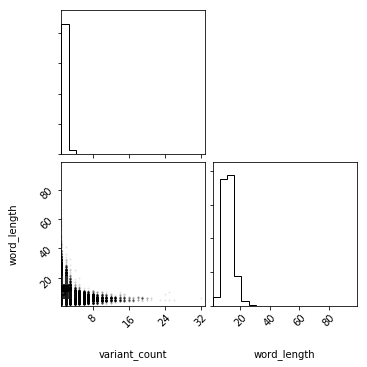

In [47]:
corner.corner(df);

Also not surprising: longer words, less variants.

In [48]:
websites.anahash.groupby('variant_id').count()

,word
variant_id,
0,895008
1,130346
2,35616
3,16213
4,8418
5,4861
6,2977
7,1889
8,1203


# confuslist.index

This file is huge, 1.8G, so we need some other sort of handling, pandas will surely crash on anything but a supercomputer.

In [5]:
websites.confuslist_index = pd.read_csv('sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.clean.confuslist.index',
                                        memory_map=True, sep='#', nrows=10, index_col=0,
                                        names=['confusion', 'word_hashes'])

In [6]:
websites.confuslist_index

,word_hashes
confusion,
254219,"72867967463,74038042345,75209415207,7576004993..."
393216,"132171266578,164996371986,176326190602"
658326,"121627899375,121975124181,125180134006,1414074..."
684816,"138997537243,149990243935,154141013182,1741099..."
1164418,"84636801790,85047784391,86310486073,8697824953..."
1173721,"80614024263,80657105013,81187812544,8178409914..."
1190068,"67676465299,69442826782,71469964105,7218882455..."
1391727,"85478414561,86121676092,86741116243,8862592951..."
1638659,"71938173924,72490106635,72511962205,7306389491..."


If we were to load this in similarly to the anahashes, with a MultiIndex, how much memory would that take? It would increase the number of columns to three (even though the second index could be a small int probably), so $3 * 8 = 24$ bytes per word hash. Number of word hashes is number of commas plus number of new lines in the file. This counts commas:
```sh
tr -cd ',' < WR-P-E-I_web_sites.wordfreqlist.tsv.clean.confuslist.index | wc -c
```
This counts newlines:
```sh
wc -l WR-P-E-I_web_sites.wordfreqlist.tsv.clean.confuslist.index
```

In [7]:
commas = 148610673
newlines = 250747
commas + newlines, (commas + newlines) * 24, (commas + newlines) * 14

(148861420, 3572674080, 2084059880)

Oi, 3.5G, more than expected from just the text file size... Actually, we can probably just use uint16 for the second index and uint32 for the confusion, only the actual hashes must be uint64, so that would sum to just 14 bytes per line, a total of about 2G then.

In [8]:
commas/newlines

592.6717886953782

That should be safely less than 65535, so then indeed a uint16 for the second column would be possible.

Ok, let's try it out then, developed this in about 1.5 hours:

In [38]:
import ticcl_output_reader

In [39]:
%timeit confusion_array, confusion_word_index_array, word_anahash_array = ticcl_output_reader.load_confuslist_index("sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.clean.confuslist.index.head")

4.45 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
def get_confuslist_index_head():
    df_tuples = pd.read_csv('sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.clean.confuslist.index.head',
                        sep='#', index_col=0, names=['confusion', 'word_hashes'],
                        converters={'word_hashes': lambda w: tuple(w.split(','))})
    df = df_tuples['word_hashes'].apply(pd.Series, 1).stack().to_frame()
    df.index.rename(["confusion", "list_index"], inplace=True)
    df.rename({0: 'word_hash'}, axis='columns', inplace=True)
    return df

In [41]:
%timeit get_confuslist_index_head()

377 ms ± 82.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
200/4

50.0

Yay! Is it correct though?

Not immediately, had to fix some bugs.

In [43]:
cpp_index = ticcl_output_reader.load_confuslist_index("sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.clean.confuslist.index.head")

In [44]:
cpp_index

(array([ 254219,  254219,  254219, ..., 1806002, 1806002, 1806002],
       dtype=uint32),
 array([ 0,  1,  2, ...,  9, 10, 11], dtype=uint16),
 array([ 72867967463,  74038042345,  75209415207, ..., 188955678071,
        200922731816, 257452836091], dtype=uint64))

In [45]:
cpp_index_df = pd.DataFrame.from_records({"confusion": cpp_index[0],
                                          "list_index": cpp_index[1],
                                          "word_hash": cpp_index[2]}, index=["confusion", "list_index"])

In [46]:
pandas_index = get_confuslist_index_head()

In [47]:
all(cpp_index_df.index == pandas_index.index)

True

In [48]:
cpp_index_df.values == pandas_index.values

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [49]:
cpp_index_df.head(5)

word_hash
confusion list_index             
254219    0           72867967463
          1           74038042345
          2           75209415207
          3           75760049938
          4           75852676738

In [50]:
pandas_index.head(5)

word_hash
confusion list_index             
254219    0           72867967463
          1           74038042345
          2           75209415207
          3           75760049938
          4           75852676738

Odd, they seem equal...

In [51]:
cpp_index_df.dtypes

word_hash    uint64
dtype: object

In [52]:
pandas_index.dtypes

word_hash    object
dtype: object

Ahhh, yeah ok. That may also explain the slowness...

In [53]:
def get_confuslist_index_head2():
    df_tuples = pd.read_csv('sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.clean.confuslist.index.head',
                        sep='#', index_col=0, names=['confusion', 'word_hashes'],
                        converters={'word_hashes': lambda w: tuple(w.split(','))})
    df = df_tuples['word_hashes'].apply(pd.Series, 1).stack().astype('uint64').to_frame()
    df.index.rename(["confusion", "list_index"], inplace=True)
    df.rename({0: 'word_hash'}, axis='columns', inplace=True)
    return df

In [54]:
pandas_index = get_confuslist_index_head2()

In [55]:
pandas_index.equals(cpp_index_df)

True

Whoohoo!

And timing on this?

In [153]:
%timeit get_confuslist_index_head2()

424 ms ± 42.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Same, good.

A Redditor came up with the suggestion to do it in pure Python, let's try that:

In [141]:
def get_confuslist_index_head_pure_python():
    with open('sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.clean.confuslist.index.head') as f:
        dc = {}
        for line in f:
            if not line:
                continue
            key, _, value = line.partition("#")
            values = value.rstrip("\n").split(",")
            dc[int(key)] = values
    return dc

In [22]:
%timeit get_confuslist_index_head_pure_python()

827 µs ± 85.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Holy crap, but what does it look like?

In [142]:
pure_py = get_confuslist_index_head_pure_python()

In [24]:
# pure_py

Right, so I'll need to still convert to three columns here as well:

In [146]:
def df_confuslist_index_head_pure_python():
    with open('sonar_ticcl/WR-P-E-I_web_sites.wordfreqlist.tsv.clean.confuslist.index.head') as f:
        dc = {}
        for line in f:
            if not line:
                continue
            key, _, value = line.partition("#")
            values = value.rstrip("\n").split(",")
            dc[int(key)] = values
    df = pd.DataFrame.from_dict(dc, orient='index').stack().astype('uint64').to_frame()
    df.index.rename(["confusion", "list_index"], inplace=True)
    df.rename({0: 'word_hash'}, axis='columns', inplace=True)
    return df

In [147]:
pure_py_df = df_confuslist_index_head_pure_python()

In [150]:
pandas_index.equals(pure_py_df)

True

Ok, then we time that...

In [154]:
%timeit df_confuslist_index_head_pure_python()

418 ms ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# short.ldcalc

# ldcalc.ambi

# ldcalc

# ldcalc.ranked